In [2188]:
import yfinance as yf
import pandas as pd
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")


In [2189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import unicodedata
from datetime import datetime, time, timedelta
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import ast

In [2190]:
# ==== BACA DATA ====
# List of stock tickers (Indonesian example)
# stocks = ["BBRI.JK", "BMRI.JK", "TLKM.JK"]
lq45_stocks = [
    "ACES.JK", "ADMR.JK", "ADRO.JK", "AKRA.JK", "AMMN.JK", "AMRT.JK", "ANTM.JK", "ARTO.JK", 
    "ASII.JK", "BBCA.JK", "BBNI.JK", "BBRI.JK", "BBTN.JK", "BMRI.JK", "BRIS.JK", "BRPT.JK", 
    "BUKA.JK", "CPIN.JK", "ESSA.JK", "EXCL.JK", "GOTO.JK", "ICBP.JK", "INCO.JK", "INDF.JK", 
    "INKP.JK", "INTP.JK", "ISAT.JK", "ITMG.JK", "JSMR.JK", "KLBF.JK", "MAPI.JK", "MBMA.JK", 
    "MDKA.JK", "MEDC.JK", "MTEL.JK", "PGAS.JK", "PGEO.JK", "PTBA.JK", "SIDO.JK", "SMGR.JK", 
    "SMRA.JK", "TLKM.JK", "TOWR.JK", "UNTR.JK", "UNVR.JK"
]


def get_stock_data(stock):
    """Fetch financial metrics, historical returns, and all closing prices with timestamps for a stock."""
    try:
        # Initialize ticker object
        stock_data = yf.Ticker(stock)

        # Fetch financials (ROA and ROE calculation)
        income_statement = stock_data.financials
        balance_sheet = stock_data.balance_sheet

        # Extract Net Income, Total Assets, and Shareholder's Equity
        net_income = income_statement.loc["Net Income"].iloc[0] if "Net Income" in income_statement.index else None
        total_assets = balance_sheet.loc["Total Assets"].iloc[0] if "Total Assets" in balance_sheet.index else None
        shareholders_equity = balance_sheet.loc['Stockholders Equity'].iloc[0] if 'Stockholders Equity' in balance_sheet.index else None

        roa = net_income / total_assets if total_assets else None
        roe = net_income / shareholders_equity if shareholders_equity else None

        # Fetch market capitalization
        market_cap = stock_data.info.get("marketCap", None)

        # Fetch historical data for returns calculation and closing prices
        hist_data = stock_data.history(period="1y")  # Last 1 year of data
        hist_data["Daily Return"] = hist_data["Close"].pct_change()

        mean_return = hist_data["Daily Return"].mean() if not hist_data["Daily Return"].isnull().all() else None
        variance_return = hist_data["Daily Return"].var() if not hist_data["Daily Return"].isnull().all() else None

        # Get all closing prices with timestamps
        closing_prices_with_timestamps = hist_data[["Close"]].reset_index()  # Reset index to include dates
        # Convert the 'Date' to the desired format 'Y-m-d'
        closing_prices_with_timestamps["Date"] = closing_prices_with_timestamps["Date"].dt.strftime('%Y-%m-%d')

        closing_prices_with_timestamps = closing_prices_with_timestamps[["Date", "Close"]].to_dict(orient='records')  # Convert to list of dicts

        if stock =='MEDC.JK':
            roa = 0.0510
            roe = 0.2169
        return {
            "Ticker": stock,
            "ROA": roa,
            "ROE": roe,  # Updated to include ROA, but you may need to replace with correct ROE
            "Market Cap": market_cap,
            "Mean Return": mean_return,
            "Variance Return": variance_return,
            "Closing Prices with Timestamps": closing_prices_with_timestamps,
        }
    except Exception as e:
        print(f"Error fetching data for {stock}: {e}")
        return {
            "Ticker": stock,
            "ROA": None,
            "ROE": None,
            "Market Cap": None,
            "Mean Return": None,
            "Variance Return": None,
            "Closing Prices with Timestamps": None,
        }

# Loop through all tickers and collect data
# results = [get_stock_data(stock) for stock in lq45_stocks]
# df = pd.DataFrame(results)
# df

# Optionally, save to CSV for future use:
# # df.to_csv("New_Data Saham dan Finansial LQ45.csv", index = False)


In [2191]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Menghitung 252 hari yang lalu dari hari ini
end_date = datetime.today()
start_date = end_date - timedelta(days=252)

# Format tanggal dalam format yang diterima oleh yfinance
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Fungsi untuk mendapatkan data saham
def get_stock_data(stock):
    try:
        # Inisialisasi objek ticker
        stock_data = yf.Ticker(stock)

        # Mengambil data historis untuk rentang waktu yang spesifik
        hist_data = stock_data.history(start=start_date_str, end=end_date_str)  # Data selama 252 hari

        # Menghitung return harian
        hist_data["Daily Return"] = hist_data["Close"].pct_change()

        mean_return = hist_data["Daily Return"].mean() if not hist_data["Daily Return"].isnull().all() else None
        variance_return = hist_data["Daily Return"].var() if not hist_data["Daily Return"].isnull().all() else None

        # Mendapatkan harga penutupan dengan timestamp
        closing_prices_with_timestamps = hist_data[["Close"]].reset_index()  # Reset index untuk memasukkan tanggal
        closing_prices_with_timestamps["Date"] = closing_prices_with_timestamps["Date"].dt.strftime('%Y-%m-%d')

        closing_prices_with_timestamps = closing_prices_with_timestamps[["Date", "Close"]].to_dict(orient='records')  # Mengubah menjadi list of dicts

        # Mengambil data keuangan dan metrik lainnya
        income_statement = stock_data.financials
        balance_sheet = stock_data.balance_sheet

        net_income = income_statement.loc["Net Income"].iloc[0] if "Net Income" in income_statement.index else None
        total_assets = balance_sheet.loc["Total Assets"].iloc[0] if "Total Assets" in balance_sheet.index else None
        shareholders_equity = balance_sheet.loc['Stockholders Equity'].iloc[0] if 'Stockholders Equity' in balance_sheet.index else None

        roa = net_income / total_assets if total_assets else None
        roe = net_income / shareholders_equity if shareholders_equity else None

        # Mengambil kapitalisasi pasar
        market_cap = stock_data.info.get("marketCap", None)
        if stock =='MEDC.JK':
            roa = 0.0510
            roe = 0.2169
        return {
            "Ticker": stock,
            "ROA": roa,
            "ROE": roe,
            "Market Cap": market_cap,
            "Mean Return": mean_return,
            "Variance Return": variance_return,
            "Closing Prices with Timestamps": closing_prices_with_timestamps,
        }
    except Exception as e:
        print(f"Error fetching data for {stock}: {e}")
        return {
            "Ticker": stock,
            "ROA": None,
            "ROE": None,
            "Market Cap": None,
            "Mean Return": None,
            "Variance Return": None,
            "Closing Prices with Timestamps": None,
        }

# Mengambil data untuk seluruh saham
# results = [get_stock_data(stock) for stock in lq45_stocks]

# # Membuat dataframe dari hasilnya
# df = pd.DataFrame(results)

# # Menampilkan hasil
# print(df)


In [2192]:
data = pd.read_csv("New_Data Saham dan Finansial LQ45.csv")
# data = df.copy()
data.set_index("Ticker", inplace=True)
data.drop(['Closing Prices with Timestamps'], axis = 1, inplace = True)
data.head()

,ROA,ROE,Market Cap,Mean Return,Variance Return
Ticker,,,,,
ACES.JK,0.098476,0.124282,13182707957760,0.000655,0.000534
ADMR.JK,0.260126,0.451713,53555809484800,0.000354,0.000646
ADRO.JK,0.156735,0.242362,71052591890432,0.002643,0.000822
AKRA.JK,0.091898,0.246865,25658361118720,0.000129,0.000345
AMMN.JK,0.027717,0.055417,683483982725120,0.001989,0.000777


In [2193]:
scaler = StandardScaler()
df_scaled1 = pd.DataFrame(scaler.fit_transform(data), columns = scaler.get_feature_names_out(), index = data.index)
df_scaled = df_scaled1.drop(['ROA'], axis = 1)

7746, 7523

rand 5098 bagus kalo 252

In [2194]:
rnd = np.random.randint(0, 10000)
print(rnd)

6458


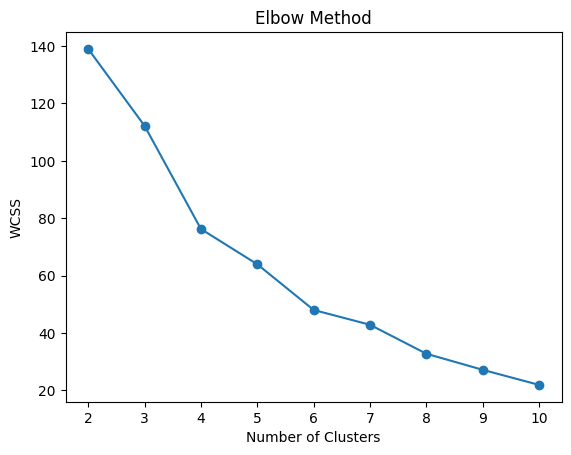

In [2195]:
wcss = []

# Specify the range of cluster numbers to try
num_clusters_range = range(2, 11)

# Perform K-Means clustering for different numbers of clusters
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=rnd)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(num_clusters_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

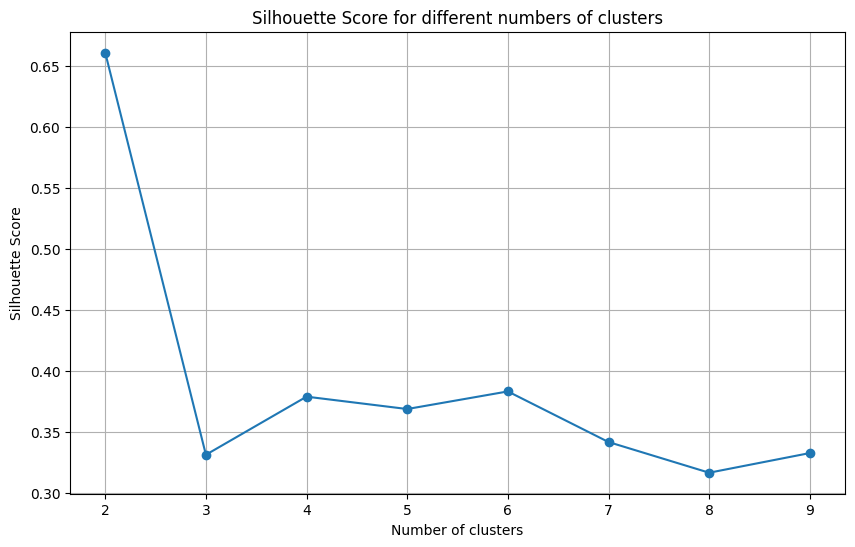

In [2196]:
silhouette_scores = []
cluster_range = range(2, 10)  # Ubah range ini sesuai kebutuhan Anda

for n_clusters in cluster_range:
    km_cluster = KMeans(n_clusters = n_clusters, random_state = rnd)
    cluster_labels = km_cluster.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 4. Plot Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [2197]:

kmeans_cluster = KMeans(n_clusters = 3,random_state=rnd)
cluster_labels = kmeans_cluster.fit_predict(df_scaled)

# 4. Calculate Evaluation Metrics
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
davies_bouldin_avg = davies_bouldin_score(df_scaled, cluster_labels)
calinski_harabasz_avg = calinski_harabasz_score(df_scaled, cluster_labels)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_avg}')

# 5. Add cluster labels to the original DataFrame (optional)
data['Cluster'] = cluster_labels

Silhouette Score: 0.3312181617988555
Davies-Bouldin Index: 1.1171187102222262
Calinski-Harabasz Index: 12.688332056488967


In [2198]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
GOTO.JK -1.670984 -2.383206   91717776703488    -0.000042         0.001415   
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
BRIS.JK  0.016129  0.147235  137004020924416     0.002639         0.000720   

         Cluster  sharpe_ratio  
Ticker                          
GOTO.JK        0     -0.007451  
PGAS.JK        1      0.097624  
BRIS.JK        2      0.089507  


# Cluster Analysis

In [2199]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

In [2200]:
df_final = df_scaled1.drop(['ROA'], axis = 1)
df_final.head()

,ROE,Market Cap,Mean Return,Variance Return
Ticker,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084
ADMR.JK,0.778213,-0.325757,0.133485,0.311211
ADRO.JK,0.293330,-0.248688,2.254371,0.823429
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337
AMMN.JK,-0.139658,2.448907,1.647973,0.691505


## KMeans

In [2201]:
# Opsional: Tuning parameter eps dan min_samples
df_kme = df_final.copy()

# GMM
kmeans = KMeans(n_clusters = 3, random_state = 7523)
kmeans.fit(df_kme)
labelg = kmeans.predict(df_kme)

unique_labels = np.unique(labelg)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_kme, labelg)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_kme, labelg)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_kme, labelg)}')

df_kme['cluster'] = labelg
data['Cluster'] = labelg

# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)


print(df_kme.cluster.value_counts())
df_kme.head()

Clusters present: [0 1 2]
Clusters sizes: [26 15  4] 

Silhouette Score: 0.1876610631591391
Calinski-Harabasz Index: 11.726280359577002
Davies-Bouldin Index: 1.2225726311316092
              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
ADMR.JK  0.260126  0.451713   53555809484800     0.000354         0.000646   
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   

         Cluster  sharpe_ratio  
Ticker                          
ADMR.JK        0      0.004564  
PGAS.JK        1      0.097624  
AMMN.JK        2      0.062818  
cluster
0    26
1    15
2     4
Name: count, dtype: int64


,ROE,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084,1
ADMR.JK,0.778213,-0.325757,0.133485,0.311211,0
ADRO.JK,0.293330,-0.248688,2.254371,0.823429,1
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.139658,2.448907,1.647973,0.691505,2


64.99822785009573 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

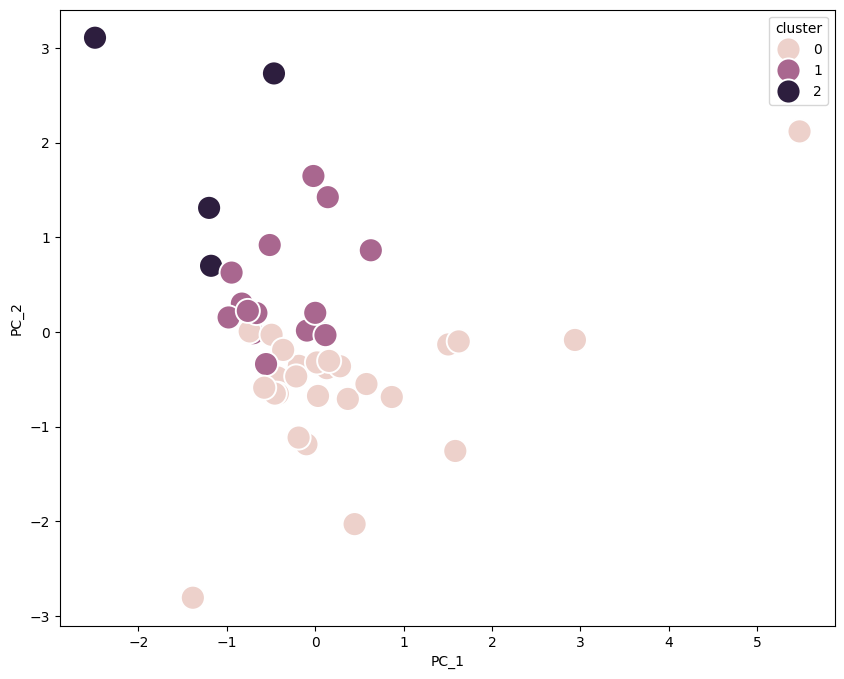

In [2202]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_kme.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_kme.index)

df_pca2 = pd.concat([df_pca2, df_kme.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [2203]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_kme.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_kme.index)

df_pca_3 = pd.concat([df_pca_3, df_kme.cluster], axis = 1)
# df_pca1.head()

In [2204]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,0.081060,-0.011719,-0.645003,1
ADMR.JK,-0.185258,-0.358235,-0.417066,0
ADRO.JK,0.141843,1.422983,-1.696032,1
AKRA.JK,-0.427134,-0.481004,-0.351792,0
AMMN.JK,-0.467157,2.729693,0.706150,2


In [2205]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

## Gaussian Mixture

In [2206]:
data = pd.read_csv("New_Data Saham dan Finansial LQ45.csv")
# data = df.copy()
data.set_index("Ticker", inplace=True)
data.drop(['Closing Prices with Timestamps'], axis = 1, inplace = True)
data.head()

,ROA,ROE,Market Cap,Mean Return,Variance Return
Ticker,,,,,
ACES.JK,0.098476,0.124282,13182707957760,0.000655,0.000534
ADMR.JK,0.260126,0.451713,53555809484800,0.000354,0.000646
ADRO.JK,0.156735,0.242362,71052591890432,0.002643,0.000822
AKRA.JK,0.091898,0.246865,25658361118720,0.000129,0.000345
AMMN.JK,0.027717,0.055417,683483982725120,0.001989,0.000777


In [2207]:
scaler = StandardScaler()
df_scaled1 = pd.DataFrame(scaler.fit_transform(data), columns = scaler.get_feature_names_out(), index = data.index)
df_scaled = df_scaled1.drop(['ROA'], axis = 1)

In [2208]:
data = pd.read_csv("New_Data Saham dan Finansial LQ45.csv")
data.set_index("Ticker", inplace=True)
data.drop(['Closing Prices with Timestamps'], axis = 1, inplace = True)
data.head()

scaler = StandardScaler()
df_scaled1 = pd.DataFrame(scaler.fit_transform(data), columns = scaler.get_feature_names_out(), index = data.index)
df_scaled = df_scaled1.drop(['ROA'], axis = 1)


df_gmm = df_scaled.copy()

# GMM
gmm = GaussianMixture(n_components = 3, random_state=42)
gmm.fit(df_gmm)
labelg = gmm.predict(df_gmm)



unique_labels = np.unique(labelg)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_gmm, labelg)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_gmm, labelg)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_gmm, labelg)}')

df_gmm['cluster'] = labelg
data['Cluster'] = labelg

# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

print(df_gmm.cluster.value_counts())
df_gmm.head()

Clusters present: [0 1 2]
Clusters sizes: [10 34  1] 

Silhouette Score: 0.339741582822534
Calinski-Harabasz Index: 10.159000831136922
Davies-Bouldin Index: 1.1273667687682063
              ROA       ROE        Market Cap  Mean Return  Variance Return  \
Ticker                                                                        
ADMR.JK  0.260126  0.451713    53555809484800     0.000354         0.000646   
PGAS.JK  0.042140  0.103040    38422777430016     0.002017         0.000332   
BBCA.JK  0.034542  0.200693  1241995691425792     0.000782         0.000194   

         Cluster  sharpe_ratio  
Ticker                          
ADMR.JK        0      0.004564  
PGAS.JK        1      0.097624  
BBCA.JK        2      0.039002  
cluster
1    34
0    10
2     1
Name: count, dtype: int64


,ROE,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084,1
ADMR.JK,0.778213,-0.325757,0.133485,0.311211,0
ADRO.JK,0.293330,-0.248688,2.254371,0.823429,1
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337,1
AMMN.JK,-0.139658,2.448907,1.647973,0.691505,1


In [2209]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE        Market Cap  Mean Return  Variance Return  \
Ticker                                                                        
ADMR.JK  0.260126  0.451713    53555809484800     0.000354         0.000646   
PGAS.JK  0.042140  0.103040    38422777430016     0.002017         0.000332   
BBCA.JK  0.034542  0.200693  1241995691425792     0.000782         0.000194   

         Cluster  sharpe_ratio  
Ticker                          
ADMR.JK        0      0.004564  
PGAS.JK        1      0.097624  
BBCA.JK        2      0.039002  


64.99822785009573 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

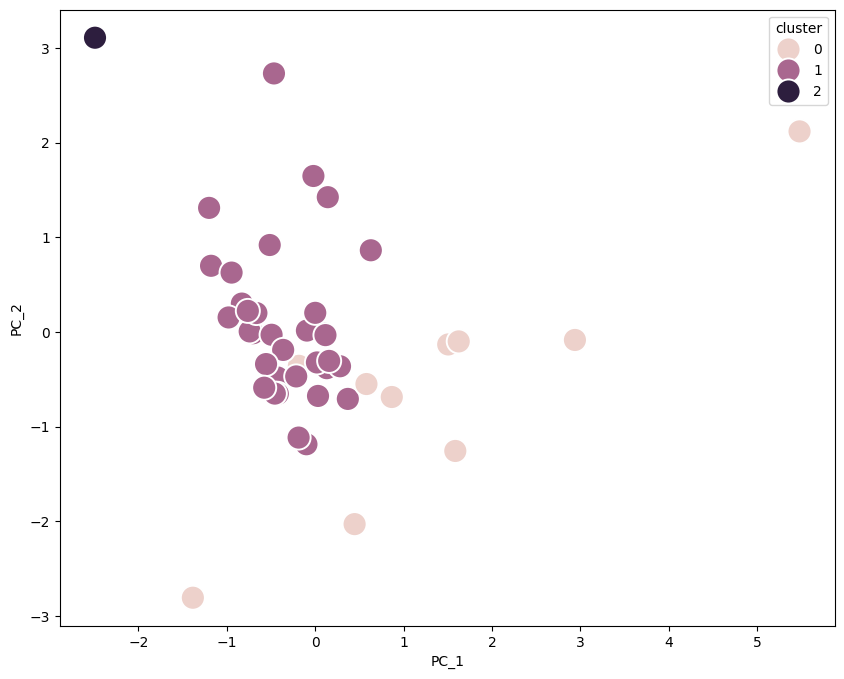

In [2210]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_gmm.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_gmm.index)

df_pca2 = pd.concat([df_pca2, df_gmm.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [2211]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_gmm.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_gmm.index)

df_pca_3 = pd.concat([df_pca_3, df_gmm.cluster], axis = 1)
# df_pca1.head()

In [2212]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,0.081060,-0.011719,-0.645003,1
ADMR.JK,-0.185258,-0.358235,-0.417066,0
ADRO.JK,0.141843,1.422983,-1.696032,1
AKRA.JK,-0.427134,-0.481004,-0.351792,1
AMMN.JK,-0.467157,2.729693,0.706150,1


In [2213]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# Cek asumsi portfolio terpilih

In [2214]:
# Opsional: Tuning parameter eps dan min_samples
df_kme = df_final.copy()

# GMM
random_state_value = np.random.randint(0, 10000)

kmeans = KMeans(n_clusters = 3, random_state = 5098)
print(random_state_value)
kmeans.fit(df_kme)
labelg = kmeans.predict(df_kme)

unique_labels = np.unique(labelg)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_kme, labelg)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_kme, labelg)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_kme, labelg)}')

df_kme['cluster'] = labelg
data['Cluster'] = labelg

# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)


print(df_kme.cluster.value_counts())

3249
Clusters present: [0 1 2]
Clusters sizes: [ 4 36  5] 

Silhouette Score: 0.4640177656249543
Calinski-Harabasz Index: 16.57620566042255
Davies-Bouldin Index: 0.9719186427710209
              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
ARTO.JK  0.003398  0.008659   36721051828224    -0.000005         0.001129   

         Cluster  sharpe_ratio  
Ticker                          
AMMN.JK        0      0.062818  
PGAS.JK        1      0.097624  
ARTO.JK        2     -0.007232  
cluster
1    36
2     5
0     4
Name: count, dtype: int64


In [2215]:
# Opsional: Tuning parameter eps dan min_samples
df_kme = df_final.copy()

# GMM
random_state_value = np.random.randint(0, 10000)

kmeans = KMeans(n_clusters = 4, random_state = 7746)
print(random_state_value)
kmeans.fit(df_kme)
labelg = kmeans.predict(df_kme)

unique_labels = np.unique(labelg)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_kme, labelg)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_kme, labelg)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_kme, labelg)}')

df_kme['cluster'] = labelg
data['Cluster'] = labelg

# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)


print(df_kme.cluster.value_counts())

7814
Clusters present: [0 1 2 3]
Clusters sizes: [17 23  4  1] 

Silhouette Score: 0.2217813920782776
Calinski-Harabasz Index: 13.323682312466934
Davies-Bouldin Index: 1.107593148975228
              ROA       ROE        Market Cap  Mean Return  Variance Return  \
Ticker                                                                        
BBCA.JK  0.034542  0.200693  1241995691425792     0.000782         0.000194   
PGAS.JK  0.042140  0.103040    38422777430016     0.002017         0.000332   
ARTO.JK  0.003398  0.008659    36721051828224    -0.000005         0.001129   
GOTO.JK -1.670984 -2.383206    91717776703488    -0.000042         0.001415   

         Cluster  sharpe_ratio  
Ticker                          
BBCA.JK        0      0.039002  
PGAS.JK        1      0.097624  
ARTO.JK        2     -0.007232  
GOTO.JK        3     -0.007451  
cluster
1    23
0    17
2     4
3     1
Name: count, dtype: int64


In [2216]:
def semideviation(r):
    # Compute the semideviation of a return series.
    is_negetive= r<0
    return np.std(r[is_negetive], ddof=0, axis=0)

def var_historic(r,level= 5):
    # Compute the historic Value-at-Risk of a return series.
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

def cvar_historic(r,level=5):
    # Compute the historic Conditional Value-at-Risk of a return series.
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
    

def skewness(r):
    # Compute the skewness of a return series.
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    skewness = exp / sigma_r**3
    return skewness

def kurtosis(r):
    # Compute the kurtosis of a return series.
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    kurtosis = exp / sigma_r**4
    return kurtosis

def is_normal(r,level =0.01, alternative = 'two-sided'):
    # Apply the Jarque-Bera test to determine if a return series is normal.
    statistic, p_value = ss.kstest(r, 'norm', args=(np.mean(r), np.std(r)))
    if alternative == 'two-sided':
        return p_value
    elif alternative == 'greater':
        return p_value > level / 2
    elif alternative == 'less':
        return p_value < level / 2
    else:
        raise ValueError("Invalid alternative hypothesis")
    
import numpy as np
import scipy.stats as ss

def goodness_of_fit(data1, dist, level=0.01, alternative='two-sided'):
    data = -data1
    """
    Apply the Kolmogorov-Smirnov test to determine goodness of fit for a given distribution.

    Parameters:
    - data: array-like, the sample data to test.
    - dist: str, the distribution name ('t', 'lognorm', 'gev').
    - level: float, significance level for the test.
    - alternative: str, 'two-sided', 'greater', or 'less'.

    Returns:
    - p_value: float, the p-value of the test.
    - result: bool, whether the null hypothesis (data follows the given distribution) is rejected.
    """
    # Estimate distribution parameters
    if dist == 't':
        params = ss.t.fit(data)
        cdf = lambda x: ss.t.cdf(x, *params)
    elif dist == 'lognorm':
        params = ss.lognorm.fit(data, floc=0)  # Lognormal distribution with location fixed to 0
        cdf = lambda x: ss.lognorm.cdf(x, *params)
    elif dist == 'gev':
        params = ss.genextreme.fit(data)
        cdf = lambda x: ss.genextreme.cdf(x, *params)
    else:
        raise ValueError("Invalid distribution name. Choose 't', 'lognorm', or 'gev'.")

    # Perform KS test
    statistic, p_value = ss.kstest(data, cdf, alternative=alternative)

    # Determine if null hypothesis is rejected
    if alternative == 'two-sided':
        result = p_value < level
    elif alternative == 'greater':
        result = p_value < level / 2
    elif alternative == 'less':
        result = p_value < level / 2
    else:
        raise ValueError("Invalid alternative hypothesis")

    return p_value

In [2217]:
def summary_stats(r):
    # caviar_result, model_summary = calculate_caviar(r, quantile=0.05)
    # Compute summary statistics for a return series.
    stats = {
        "Mean": r.mean(),
        "Median": r.median(),
        "Variance": r.var(),
        "Standard Deviation": r.std(),
        "Normality": is_normal(r,level =0.05, alternative = 'two-sided'),
        "Student-t": goodness_of_fit(r, 't'),
        # "Log Normal": goodness_of_fit(r, 'lognorm'),
        "GEV": goodness_of_fit(r, 'gev'),
        "Skewness": skewness(r),
        "Kurtosis": kurtosis(r),
        # "Semideviation": semideviation,
        # "VaR (5%)": var_historic(r, level=5),
        # "CVaR (5%)": cvar_historic(r, level=5),
        # "CAViaR (5%)": caviar_result['VaR_Prediction'].tail(1).values[0],
    }
    return pd.Series(stats)

In [2218]:
data_df = pd.read_csv("New_Data Saham dan Finansial LQ45.csv")
# data_df = df.copy()
data_df.head()

,Ticker,ROA,ROE,Market Cap,Mean Return,Variance Return,Closing Prices with Timestamps
0,ACES.JK,0.098476,0.124282,13182707957760,0.000655,0.000534,"[{'Date': '2023-12-06', 'Close': 701.563964843..."
1,ADMR.JK,0.260126,0.451713,53555809484800,0.000354,0.000646,"[{'Date': '2023-12-06', 'Close': 1300.0}, {'Da..."
2,ADRO.JK,0.156735,0.242362,71052591890432,0.002643,0.000822,"[{'Date': '2023-12-06', 'Close': 1362.95568847..."
3,AKRA.JK,0.091898,0.246865,25658361118720,0.000129,0.000345,"[{'Date': '2023-12-06', 'Close': 1313.31225585..."
4,AMMN.JK,0.027717,0.055417,683483982725120,0.001989,0.000777,"[{'Date': '2023-12-06', 'Close': 6425.0}, {'Da..."


In [2219]:
# Pilih ticker tertentu
selected_tickers = ["ADMR.JK", "BBCA.JK", "PGAS.JK"]

# Filter data berdasarkan ticker tertentu
filtered_df = data_df[data_df["Ticker"].isin(selected_tickers)]

# Buat DataFrame baru untuk menyimpan data harga penutupan
closing_prices = pd.DataFrame()

# Iterasi setiap baris untuk mengekstrak harga penutupan
for index, row in filtered_df.iterrows():
    ticker = row["Ticker"]
    prices = pd.DataFrame(ast.literal_eval(row["Closing Prices with Timestamps"]))  # Konversi ke DataFrame
    prices.set_index("Date", inplace=True)  # Set index menjadi Date
    prices = prices.rename(columns={"Close": ticker})  # Rename kolom menjadi nama ticker
    closing_prices = pd.concat([closing_prices, prices], axis=1)  # Gabungkan data

# Hasil akhir
closing_prices


,ADMR.JK,BBCA.JK,PGAS.JK
Date,,,
2023-12-06,1300.0,8559.092773,1020.066467
2023-12-07,1305.0,8583.408203,1001.931946
2023-12-08,1370.0,8510.461914,1001.931946
2023-12-11,1390.0,8510.461914,1001.931946
2023-12-12,1395.0,8461.830078,988.331055
...,...,...,...
2024-12-02,1250.0,9750.000000,1570.000000
2024-12-03,1250.0,10200.000000,1585.000000
2024-12-04,1275.0,10200.000000,1595.000000


In [2220]:
returns_df = closing_prices.pct_change() * 100
returns_df = returns_df.dropna()
returns_df

,ADMR.JK,BBCA.JK,PGAS.JK
Date,,,
2023-12-07,0.384615,0.284089,-1.777778
2023-12-08,4.980843,-0.849852,0.000000
2023-12-11,1.459854,0.000000,0.000000
2023-12-12,0.359712,-0.571436,-1.357467
2023-12-13,-6.451613,-0.287354,-0.917425
...,...,...,...
2024-12-02,2.040816,-2.500000,3.289474
2024-12-03,0.000000,4.615385,0.955414
2024-12-04,2.000000,0.000000,0.630915


In [2221]:
summary_stats(returns_df['ADMR.JK'])
#ADRO.JK	AMMN.JK	INDF.JK

Mean                  0.035413
Median                0.000000
Variance              6.462390
Standard Deviation    2.542123
Normality             0.224962
Student-t             0.490567
GEV                   0.141327
Skewness              0.015293
Kurtosis              3.989857
dtype: float64

In [2222]:
summary_stats(returns_df["BBCA.JK"])

Mean                  0.078182
Median                0.000000
Variance              1.943496
Standard Deviation    1.394093
Normality             0.176556
Student-t             0.479461
GEV                   0.138021
Skewness              0.307770
Kurtosis              3.857299
dtype: float64

In [2223]:
summary_stats(returns_df['PGAS.JK'])

Mean                  0.201693
Median                0.000000
Variance              3.320109
Standard Deviation    1.822117
Normality             0.059168
Student-t             0.338449
GEV                   0.002122
Skewness              0.873409
Kurtosis              9.313761
dtype: float64

# SA

In [2288]:
np.random.seed(42)

In [2300]:
# Calculate covariance of historical returns
cov_hist_return=returns_df.cov()
# For ease of calculations make covariance of same variable as zero.
for i in range(3):
    cov_hist_return.iloc[i][i]=0
# Calculate the mean of historical returns
mean_hist_return=returns_df.mean()
# Calculate Standard deviation of historical returns:
sd_hist_return=returns_df.std()

In [2301]:
def mean_portfolio_return(weights):
    return np.sum(np.multiply(weights,mean_hist_return))

def var_portfolio_return(weights):
    part_1 = np.sum(np.multiply(weights,sd_hist_return)**2)
    temp_lst=[]
    for i in range(3):
        for j in range(3):
            temp=cov_hist_return.iloc[i][j] * weights[i] * weights[j]
            temp_lst.append(temp)
    part_2=np.sum(temp_lst)
    return part_1+part_2

rf = 0.06 / 252

def fitness_function(weights, rf = rf, lower = 1e-3):
    """Calculate portfolio fitness for given weights"""
    return (mean_portfolio_return(weights)-rf)/np.sqrt(np.max([var_portfolio_return(weights), lower]))

In [2302]:
# Generates random answer in bound[a,b] with sum 1
def random_weights(n, a = -1, b = 1):
    k = np.random.uniform(a, b, (n))
    while(np.sum(k) < 1):
        k = np.random.uniform(a, b, (n))
    return k / np.sum(k)

In [2303]:
def sa(dim = 3, bound = [-1, 1], n_iter=10000, initial_temp=1000, cool_rate=0.95, rf = rf, lower = 1e-3, showlog = False):
    """Solve portfolio optimization problem using simulated annealing"""
    
    # initialize variables
    m = n_iter
    current_weights = random_weights(dim, bound[0], bound[1])  # initial weights
    best_weights = current_weights.copy()  # best observed weights
    current_fitness = fitness_function(current_weights, rf , lower)  # initial return
    best_fitness = current_fitness  # best observed return

    # iterate for m iterations
    for i in range(m):
        # decrease temperature
        temp = initial_temp * (cool_rate ** i)

        # generate new candidate
        candidate_weights = random_weights(dim, bound[0], bound[1])
        candidate_fitness = fitness_function(candidate_weights, rf , lower)

        # calculate acceptance probability
        delta = candidate_fitness - current_fitness
        if delta >= 0:
            accept_prob = 1.0
        else:
            accept_prob = np.exp(delta / temp)

        # update weights and return
        if np.random.rand() < accept_prob:
            current_weights = candidate_weights
            current_fitness = candidate_fitness

        # update best weights and return
        if current_fitness > best_fitness:
            best_weights = current_weights.copy()
            best_fitness = current_fitness
        if showlog:
            print('Iteration:',i)
            print('Expected returns of {} with risk of {}\n'.format(mean_portfolio_return(best_weights), var_portfolio_return(best_weights)))
        

    # return best weights and return
    return best_weights, best_fitness, var_portfolio_return(best_weights), mean_portfolio_return(best_weights)

In [2304]:
sol, fit, risk, ret = sa(dim = 3, n_iter = 1000, bound = [0,1], initial_temp=1000, cool_rate=0.95, rf = 0.06 / 252, lower = 1e-3, showlog = True)

Iteration: 0
Expected returns of 0.10789013549918545 with risk of 2.4145742602521305

Iteration: 1
Expected returns of 0.1219095272708919 with risk of 1.8907210422500569

Iteration: 2
Expected returns of 0.12345186976459666 with risk of 1.2135748259997716

Iteration: 3
Expected returns of 0.12345186976459666 with risk of 1.2135748259997716

Iteration: 4
Expected returns of 0.12345186976459666 with risk of 1.2135748259997716

Iteration: 5
Expected returns of 0.12345186976459666 with risk of 1.2135748259997716

Iteration: 6
Expected returns of 0.12669976430683666 with risk of 1.2076769355049126

Iteration: 7
Expected returns of 0.12669976430683666 with risk of 1.2076769355049126

Iteration: 8
Expected returns of 0.12669976430683666 with risk of 1.2076769355049126

Iteration: 9
Expected returns of 0.12669976430683666 with risk of 1.2076769355049126

Iteration: 10
Expected returns of 0.12669976430683666 with risk of 1.2076769355049126

Iteration: 11
Expected returns of 0.12669976430683666 

Iteration: 72
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 73
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 74
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 75
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 76
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 77
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 78
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 79
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 80
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 81
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 82
Expected returns of 0.1500817173021903 with risk of 1.5272946210718548

Iteration: 83
Expected returns of 0.1500817173021903 w

In [2305]:
print('Portfolio of stocks:')
for i in list(range(3)):
    print(returns_df.columns[i],':',sol[i]) 
print('\nExpected returns of ', ret, "with risk of ", risk, "and fitness ", fit)

Portfolio of stocks:
ADMR.JK : 0.006499759565613575
BBCA.JK : 0.3681240397187681
PGAS.JK : 0.6253762007156183

Expected returns of  0.15514457164077514 with risk of  1.6274088287275477 and fitness  0.12142867090034393


# Mean Variance

In [2307]:
import numpy as np

def calculate_optimal_weights(covariance_matrix):
    """
    Calculates the optimal weights for a minimum variance portfolio.

    Args:
        covariance_matrix: The covariance matrix of asset returns.

    Returns:
        A numpy array containing the optimal weights for each asset.
    """

    # Create a vector of ones with the same length as the covariance matrix
    ones_vector = np.ones(len(covariance_matrix))

    # Calculate the inverse of the covariance matrix
    inverse_covariance = np.linalg.inv(covariance_matrix)

    # Calculate the numerator of the optimal weights formula
    numerator = np.dot(inverse_covariance, ones_vector)

    # Calculate the denominator of the optimal weights formula
    denominator = np.dot(ones_vector.T, np.dot(inverse_covariance, ones_vector))

    # Calculate the optimal weights
    optimal_weights = numerator / denominator

    return optimal_weights

def sharpe_ratio(returns, weights, risk_free_rate=0.0):
    portfolio_return = np.dot(returns.mean() * 252, weights)  # Annualized return
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualized std dev
    return (portfolio_return - risk_free_rate) / portfolio_std_dev

# Example usage:
covariance_matrix = np.cov(returns_df.T)

optimal_weights = calculate_optimal_weights(covariance_matrix)

print('Portfolio of stocks using Mean Variance:')
for i in list(range(3)):
    print(returns_df.columns[i],':',optimal_weights[i]) 

print('\nExpected returns of ', mean_portfolio_return(optimal_weights), "with risk of ", var_portfolio_return(optimal_weights), "and fitness ", fitness_function(optimal_weights))

Portfolio of stocks using Mean Variance:
ADMR.JK : 0.1503007910957944
BBCA.JK : 0.5510145380696225
PGAS.JK : 0.2986846708345831

Expected returns of  0.10864441268686471 with risk of  1.121747530984809 and fitness  0.10235452108679283
